# MLB Player Performance Projection - Part 3: Modeling
 
**Project**: MLB Player Performance Projection System  
**Notebook**: 03 - Machine Learning Model Development  
**Author**: Yunjae Jung 
**Date**: January 2026
 
## Objectives
- Develop machine learning models for performance prediction
- Engineer features from historical performance data
- Train and evaluate multiple model types
- Analyze feature importance
- Select best model for deployment
 
## Context
This notebook develops the core prediction engine using historical player data to forecast future performance metrics, enabling data-driven roster decisions.


## 1. Setup & Load Data

In [48]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Machine Learning imports
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Plotting settings
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

print("✅ Libraries loaded")

✅ Libraries loaded


In [49]:
# Load processed data from notebook 01
df = pd.read_csv('../data/processed/batting_with_projections.csv')

print(f"✅ Loaded {len(df):,} player-seasons")
print(f"\nData shape: {df.shape}")
print(f"\nColumns: {df.columns.tolist()}")

✅ Loaded 5,157 player-seasons

Data shape: (5157, 33)

Columns: ['playerID', 'playerName', 'yearID', 'teamID', 'age', 'age_group', 'years_experience', 'G', 'PA', 'AB', 'H', '2B', '3B', 'HR', 'RBI', 'SB', 'BB', 'SO', 'AVG', 'OBP', 'SLG', 'OPS', 'career_G', 'career_PA', 'career_HR', 'AVG_next', 'OBP_next', 'SLG_next', 'OPS_next', 'HR_next', 'RBI_next', 'SB_next', 'PA_next']


## 2. Feature Engineering & Selection

In [50]:
# Create additional features for modeling

# Career statistics (cumulative up to current year)
df = df.sort_values(['playerID', 'yearID'])
df['career_games'] = df.groupby('playerID')['G'].cumsum()
df['career_AB'] = df.groupby('playerID')['AB'].cumsum()
df['career_H'] = df.groupby('playerID')['H'].cumsum()
df['career_HR'] = df.groupby('playerID')['HR'].cumsum()

# Career rate stats
df['career_AVG'] = df['career_H'] / df['career_AB'].replace(0, 1)
df['career_OPS'] = df.groupby('playerID')['OPS'].expanding().mean().reset_index(0, drop=True)

# Rolling averages (last 3 years)
df['last_3yr_avg_OPS'] = df.groupby('playerID')['OPS'].rolling(3, min_periods=1).mean().reset_index(0, drop=True)
df['last_3yr_avg_HR'] = df.groupby('playerID')['HR'].rolling(3, min_periods=1).mean().reset_index(0, drop=True)

# Previous season stats
df['last_season_OPS'] = df.groupby('playerID')['OPS'].shift(1)
df['last_season_AB'] = df.groupby('playerID')['AB'].shift(1)

# Age-based features
df['age_squared'] = df['age'] ** 2
df['prime_years'] = ((df['age'] >= 27) & (df['age'] <= 30)).astype(int)

# Playing time consistency
df['AB_change'] = df.groupby('playerID')['AB'].diff()

print("✅ Created additional features")
print(f"\nNew data shape: {df.shape}")

✅ Created additional features

New data shape: (5157, 45)


In [51]:
# Define target variable (next year's OPS)
df['target_next_OPS'] = df.groupby('playerID')['OPS'].shift(-1)

# Remove rows without target (last year for each player)
df_model = df.dropna(subset=['target_next_OPS']).copy()

# Also remove rows with missing critical features
df_model = df_model.dropna(subset=['last_season_OPS'])

print(f"✅ Created target variable")
print(f"\nModeling dataset: {len(df_model):,} observations")
print(f"\nTarget statistics:")
print(df_model['target_next_OPS'].describe())

✅ Created target variable

Modeling dataset: 3,100 observations

Target statistics:
count    3100.000000
mean        0.791039
std         0.098549
min         0.527364
25%         0.722001
50%         0.783576
75%         0.850800
max         1.421733
Name: target_next_OPS, dtype: float64


In [52]:
# Select features for modeling
feature_cols = [
    # Current season stats
    'age', 'age_squared', 'prime_years',
    'G', 'AB', 'H', 'HR', 'R', 'RBI', 'SB',
    'AVG', 'OBP', 'SLG', 'OPS',
    
    # Career stats
    'career_games', 'career_AB', 'career_AVG', 'career_OPS',
    
    # Rolling stats
    'last_3yr_avg_OPS', 'last_3yr_avg_HR',
    
    # Previous season
    'last_season_OPS', 'last_season_AB',
    
    # Changes
    'AB_change'
]

# Filter to features that exist and have no missing values
available_features = [col for col in feature_cols if col in df_model.columns]
df_model = df_model.dropna(subset=available_features)

print(f"Selected {len(available_features)} features:")
for i, feat in enumerate(available_features, 1):
    print(f"  {i}. {feat}")

print(f"\nFinal modeling dataset: {len(df_model):,} observations")

Selected 22 features:
  1. age
  2. age_squared
  3. prime_years
  4. G
  5. AB
  6. H
  7. HR
  8. RBI
  9. SB
  10. AVG
  11. OBP
  12. SLG
  13. OPS
  14. career_games
  15. career_AB
  16. career_AVG
  17. career_OPS
  18. last_3yr_avg_OPS
  19. last_3yr_avg_HR
  20. last_season_OPS
  21. last_season_AB
  22. AB_change

Final modeling dataset: 3,100 observations


## 3. Train-Test Split

In [53]:
# Prepare X and y
X = df_model[available_features]
y = df_model['target_next_OPS']

print(f"Feature matrix X: {X.shape}")
print(f"Target vector y: {y.shape}")

# Split data: 80% train, 20% test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print(f"\n✅ Data split complete")
print(f"Training set: {len(X_train):,} observations")
print(f"Test set: {len(X_test):,} observations")

Feature matrix X: (3100, 22)
Target vector y: (3100,)

✅ Data split complete
Training set: 2,480 observations
Test set: 620 observations


In [54]:
# Scale features (important for some models)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("✅ Features scaled")
print(f"\nFeature means after scaling: {X_train_scaled.mean(axis=0)[:5]}")
print(f"Feature stds after scaling: {X_train_scaled.std(axis=0)[:5]}")

✅ Features scaled

Feature means after scaling: [-2.43532792e-16  8.59527503e-18 -7.44923836e-17  2.06286601e-16
 -3.72461918e-17]
Feature stds after scaling: [1. 1. 1. 1. 1.]


## 4. Baseline Model: Linear Regression

In [55]:
# Train baseline linear regression
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

# Predictions
y_train_pred_lr = lr_model.predict(X_train)
y_test_pred_lr = lr_model.predict(X_test)

# Metrics
train_rmse_lr = np.sqrt(mean_squared_error(y_train, y_train_pred_lr))
test_rmse_lr = np.sqrt(mean_squared_error(y_test, y_test_pred_lr))
train_mae_lr = mean_absolute_error(y_train, y_train_pred_lr)
test_mae_lr = mean_absolute_error(y_test, y_test_pred_lr)
train_r2_lr = r2_score(y_train, y_train_pred_lr)
test_r2_lr = r2_score(y_test, y_test_pred_lr)

print("="*60)
print("LINEAR REGRESSION - Baseline Model")
print("="*60)
print(f"\nTraining Metrics:")
print(f"  RMSE: {train_rmse_lr:.4f}")
print(f"  MAE:  {train_mae_lr:.4f}")
print(f"  R²:   {train_r2_lr:.4f}")
print(f"\nTest Metrics:")
print(f"  RMSE: {test_rmse_lr:.4f}")
print(f"  MAE:  {test_mae_lr:.4f}")
print(f"  R²:   {test_r2_lr:.4f}")
print("="*60)

LINEAR REGRESSION - Baseline Model

Training Metrics:
  RMSE: 0.0758
  MAE:  0.0599
  R²:   0.3973

Test Metrics:
  RMSE: 0.0772
  MAE:  0.0602
  R²:   0.4272


## 5. Random Forest Model

In [56]:
# Train Random Forest
rf_model = RandomForestRegressor(
    n_estimators=100,
    max_depth=15,
    min_samples_split=10,
    min_samples_leaf=5,
    random_state=42,
    n_jobs=-1
)

print("Training Random Forest...")
rf_model.fit(X_train, y_train)
print("✅ Training complete")

# Predictions
y_train_pred_rf = rf_model.predict(X_train)
y_test_pred_rf = rf_model.predict(X_test)

# Metrics
train_rmse_rf = np.sqrt(mean_squared_error(y_train, y_train_pred_rf))
test_rmse_rf = np.sqrt(mean_squared_error(y_test, y_test_pred_rf))
train_mae_rf = mean_absolute_error(y_train, y_train_pred_rf)
test_mae_rf = mean_absolute_error(y_test, y_test_pred_rf)
train_r2_rf = r2_score(y_train, y_train_pred_rf)
test_r2_rf = r2_score(y_test, y_test_pred_rf)

print("\n" + "="*60)
print("RANDOM FOREST")
print("="*60)
print(f"\nTraining Metrics:")
print(f"  RMSE: {train_rmse_rf:.4f}")
print(f"  MAE:  {train_mae_rf:.4f}")
print(f"  R²:   {train_r2_rf:.4f}")
print(f"\nTest Metrics:")
print(f"  RMSE: {test_rmse_rf:.4f}")
print(f"  MAE:  {test_mae_rf:.4f}")
print(f"  R²:   {test_r2_rf:.4f}")
print("="*60)

Training Random Forest...
✅ Training complete

RANDOM FOREST

Training Metrics:
  RMSE: 0.0487
  MAE:  0.0371
  R²:   0.7511

Test Metrics:
  RMSE: 0.0794
  MAE:  0.0608
  R²:   0.3943


## 6. Gradient Boosting Model

In [57]:
# Train Gradient Boosting
gb_model = GradientBoostingRegressor(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=5,
    min_samples_split=10,
    min_samples_leaf=5,
    random_state=42
)

print("Training Gradient Boosting...")
gb_model.fit(X_train, y_train)
print("✅ Training complete")

# Predictions
y_train_pred_gb = gb_model.predict(X_train)
y_test_pred_gb = gb_model.predict(X_test)

# Metrics
train_rmse_gb = np.sqrt(mean_squared_error(y_train, y_train_pred_gb))
test_rmse_gb = np.sqrt(mean_squared_error(y_test, y_test_pred_gb))
train_mae_gb = mean_absolute_error(y_train, y_train_pred_gb)
test_mae_gb = mean_absolute_error(y_test, y_test_pred_gb)
train_r2_gb = r2_score(y_train, y_train_pred_gb)
test_r2_gb = r2_score(y_test, y_test_pred_gb)

print("\n" + "="*60)
print("GRADIENT BOOSTING")
print("="*60)
print(f"\nTraining Metrics:")
print(f"  RMSE: {train_rmse_gb:.4f}")
print(f"  MAE:  {train_mae_gb:.4f}")
print(f"  R²:   {train_r2_gb:.4f}")
print(f"\nTest Metrics:")
print(f"  RMSE: {test_rmse_gb:.4f}")
print(f"  MAE:  {test_mae_gb:.4f}")
print(f"  R²:   {test_r2_gb:.4f}")
print("="*60)

Training Gradient Boosting...
✅ Training complete

GRADIENT BOOSTING

Training Metrics:
  RMSE: 0.0503
  MAE:  0.0391
  R²:   0.7342

Test Metrics:
  RMSE: 0.0807
  MAE:  0.0620
  R²:   0.3745


## 7. Model Comparison

In [58]:
# Create comparison dataframe
results = pd.DataFrame({
    'Model': ['Linear Regression', 'Random Forest', 'Gradient Boosting'],
    'Train_RMSE': [train_rmse_lr, train_rmse_rf, train_rmse_gb],
    'Test_RMSE': [test_rmse_lr, test_rmse_rf, test_rmse_gb],
    'Train_MAE': [train_mae_lr, train_mae_rf, train_mae_gb],
    'Test_MAE': [test_mae_lr, test_mae_rf, test_mae_gb],
    'Train_R2': [train_r2_lr, train_r2_rf, train_r2_gb],
    'Test_R2': [test_r2_lr, test_r2_rf, test_r2_gb]
})

# Calculate overfitting (difference between train and test)
results['RMSE_Gap'] = results['Train_RMSE'] - results['Test_RMSE']
results['R2_Gap'] = results['Train_R2'] - results['Test_R2']

print("\n" + "="*80)
print("MODEL COMPARISON")
print("="*80)
print(results.to_string(index=False))
print("="*80)

# Find best model based on Test RMSE
best_idx = results['Test_RMSE'].idxmin()
best_model_name = results.loc[best_idx, 'Model']
print(f"\n🏆 Best Model: {best_model_name}")
print(f"   Test RMSE: {results.loc[best_idx, 'Test_RMSE']:.4f}")
print(f"   Test R²: {results.loc[best_idx, 'Test_R2']:.4f}")


MODEL COMPARISON
            Model  Train_RMSE  Test_RMSE  Train_MAE  Test_MAE  Train_R2  Test_R2  RMSE_Gap    R2_Gap
Linear Regression    0.075779   0.077193   0.059895  0.060170  0.397334 0.427193 -0.001414 -0.029860
    Random Forest    0.048704   0.079376   0.037111  0.060790  0.751056 0.394330 -0.030672  0.356726
Gradient Boosting    0.050324   0.080665   0.039051  0.062047  0.734215 0.374497 -0.030341  0.359718

🏆 Best Model: Linear Regression
   Test RMSE: 0.0772
   Test R²: 0.4272


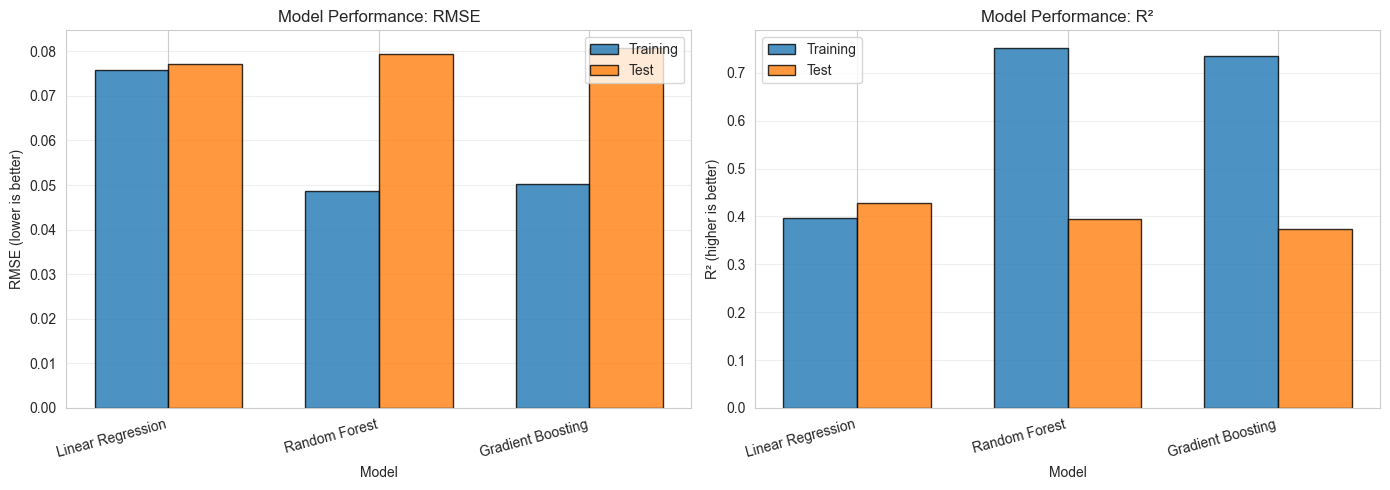


📊 Saved model comparison plot


In [59]:
# Visualize model comparison
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# RMSE comparison
x_pos = np.arange(len(results))
width = 0.35

axes[0].bar(x_pos - width/2, results['Train_RMSE'], width, 
            label='Training', alpha=0.8, edgecolor='black')
axes[0].bar(x_pos + width/2, results['Test_RMSE'], width, 
            label='Test', alpha=0.8, edgecolor='black')
axes[0].set_xlabel('Model')
axes[0].set_ylabel('RMSE (lower is better)')
axes[0].set_title('Model Performance: RMSE')
axes[0].set_xticks(x_pos)
axes[0].set_xticklabels(results['Model'], rotation=15, ha='right')
axes[0].legend()
axes[0].grid(axis='y', alpha=0.3)

# R² comparison
axes[1].bar(x_pos - width/2, results['Train_R2'], width, 
            label='Training', alpha=0.8, edgecolor='black')
axes[1].bar(x_pos + width/2, results['Test_R2'], width, 
            label='Test', alpha=0.8, edgecolor='black')
axes[1].set_xlabel('Model')
axes[1].set_ylabel('R² (higher is better)')
axes[1].set_title('Model Performance: R²')
axes[1].set_xticks(x_pos)
axes[1].set_xticklabels(results['Model'], rotation=15, ha='right')
axes[1].legend()
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('../reports/model_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n📊 Saved model comparison plot")

## 8. Feature Importance Analysis

In [60]:
# Get feature importance from Random Forest
feature_importance = pd.DataFrame({
    'Feature': available_features,
    'Importance': rf_model.feature_importances_
}).sort_values('Importance', ascending=False)

print("\n" + "="*60)
print("FEATURE IMPORTANCE (Random Forest)")
print("="*60)
print(feature_importance.to_string(index=False))
print("="*60)


FEATURE IMPORTANCE (Random Forest)
         Feature  Importance
last_3yr_avg_OPS    0.348375
      career_OPS    0.152555
             OPS    0.051768
             SLG    0.036321
      career_AVG    0.035682
 last_3yr_avg_HR    0.034240
             AVG    0.030672
 last_season_OPS    0.029988
             OBP    0.027310
       AB_change    0.025768
             RBI    0.024776
  last_season_AB    0.024247
              SB    0.023056
              HR    0.021204
               G    0.020908
       career_AB    0.020899
              AB    0.020240
               H    0.020215
    career_games    0.018947
     age_squared    0.015720
             age    0.014353
     prime_years    0.002757


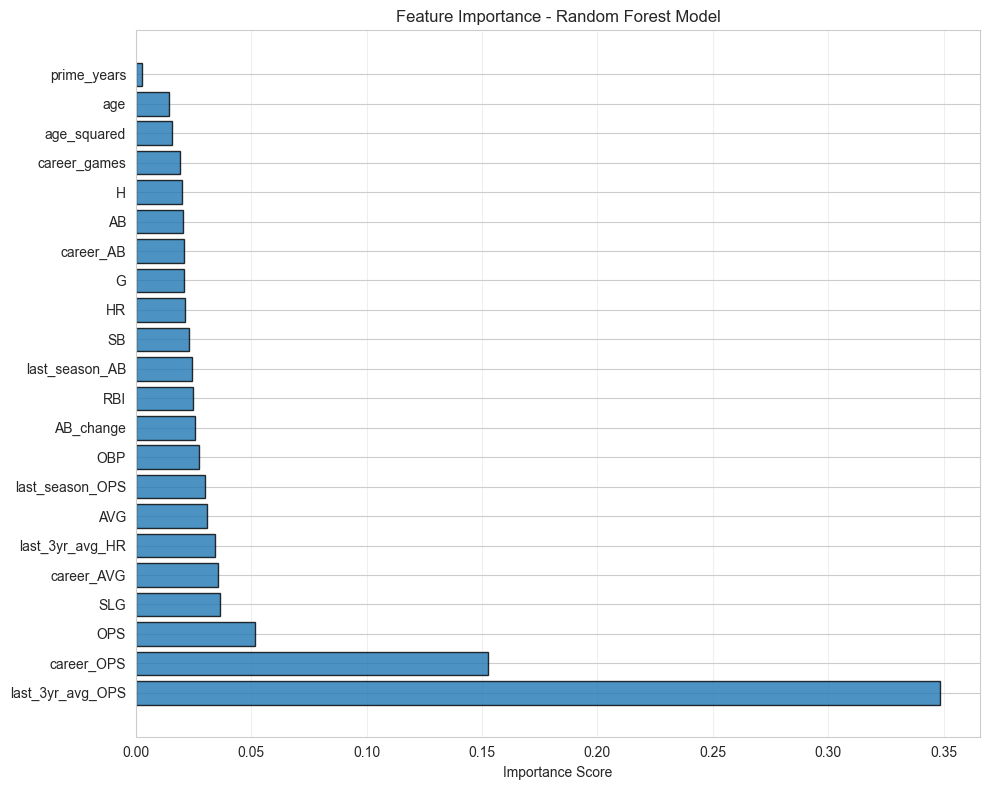


📊 Saved feature importance plot


In [61]:
# Visualize feature importance
plt.figure(figsize=(10, 8))
plt.barh(range(len(feature_importance)), feature_importance['Importance'], 
         edgecolor='black', alpha=0.8)
plt.yticks(range(len(feature_importance)), feature_importance['Feature'])
plt.xlabel('Importance Score')
plt.title('Feature Importance - Random Forest Model')
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.savefig('../reports/feature_importance.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n📊 Saved feature importance plot")

## 9. Prediction Error Analysis

In [62]:
# Analyze prediction errors for best model (Random Forest)
test_errors = y_test - y_test_pred_rf

# Create analysis dataframe
error_analysis = pd.DataFrame({
    'Actual': y_test,
    'Predicted': y_test_pred_rf,
    'Error': test_errors,
    'Abs_Error': np.abs(test_errors)
})

print("\n" + "="*60)
print("ERROR ANALYSIS")
print("="*60)
print(f"\nError Statistics:")
print(f"  Mean Error: {test_errors.mean():.4f}")
print(f"  Std Error: {test_errors.std():.4f}")
print(f"  MAE: {np.abs(test_errors).mean():.4f}")
print(f"  RMSE: {np.sqrt((test_errors**2).mean()):.4f}")

print(f"\nError Distribution:")
print(f"  Within ±0.050 OPS: {(np.abs(test_errors) <= 0.050).sum() / len(test_errors) * 100:.1f}%")
print(f"  Within ±0.100 OPS: {(np.abs(test_errors) <= 0.100).sum() / len(test_errors) * 100:.1f}%")
print(f"  Within ±0.150 OPS: {(np.abs(test_errors) <= 0.150).sum() / len(test_errors) * 100:.1f}%")
print("="*60)


ERROR ANALYSIS

Error Statistics:
  Mean Error: 0.0012
  Std Error: 0.0794
  MAE: 0.0608
  RMSE: 0.0794

Error Distribution:
  Within ±0.050 OPS: 50.6%
  Within ±0.100 OPS: 81.1%
  Within ±0.150 OPS: 93.7%


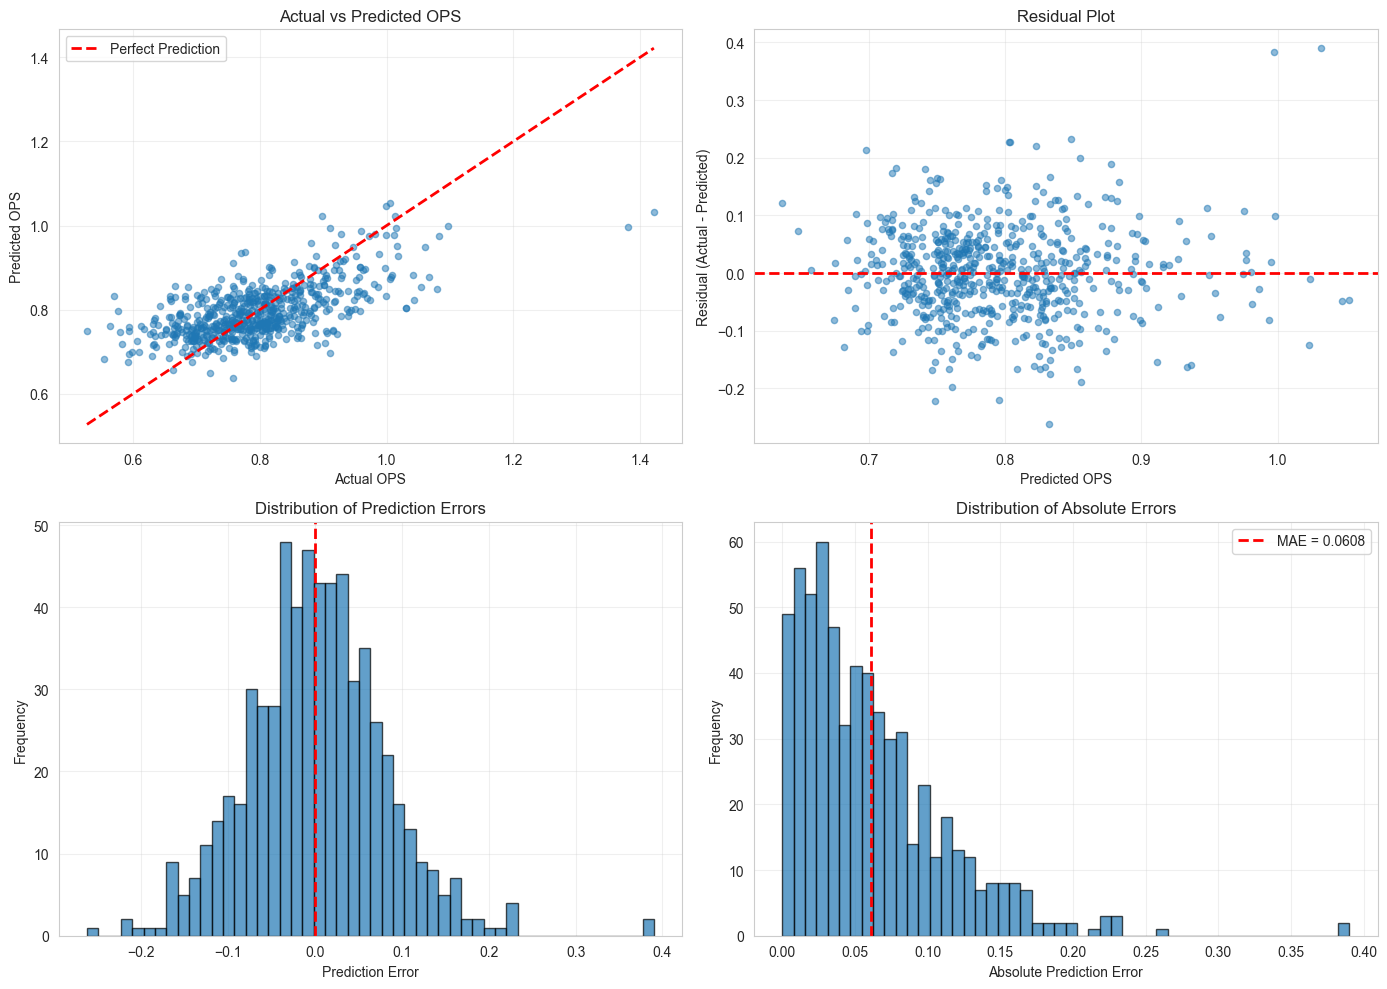


📊 Saved error analysis plots


In [63]:
# Visualize prediction errors
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Actual vs Predicted scatter
axes[0, 0].scatter(y_test, y_test_pred_rf, alpha=0.5, s=20)
axes[0, 0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 
                'r--', lw=2, label='Perfect Prediction')
axes[0, 0].set_xlabel('Actual OPS')
axes[0, 0].set_ylabel('Predicted OPS')
axes[0, 0].set_title('Actual vs Predicted OPS')
axes[0, 0].legend()
axes[0, 0].grid(alpha=0.3)

# Residual plot
axes[0, 1].scatter(y_test_pred_rf, test_errors, alpha=0.5, s=20)
axes[0, 1].axhline(0, color='red', linestyle='--', lw=2)
axes[0, 1].set_xlabel('Predicted OPS')
axes[0, 1].set_ylabel('Residual (Actual - Predicted)')
axes[0, 1].set_title('Residual Plot')
axes[0, 1].grid(alpha=0.3)

# Error distribution
axes[1, 0].hist(test_errors, bins=50, edgecolor='black', alpha=0.7)
axes[1, 0].axvline(0, color='red', linestyle='--', lw=2)
axes[1, 0].set_xlabel('Prediction Error')
axes[1, 0].set_ylabel('Frequency')
axes[1, 0].set_title('Distribution of Prediction Errors')
axes[1, 0].grid(alpha=0.3)

# Absolute error distribution
axes[1, 1].hist(np.abs(test_errors), bins=50, edgecolor='black', alpha=0.7)
axes[1, 1].axvline(test_mae_rf, color='red', linestyle='--', lw=2, 
                   label=f'MAE = {test_mae_rf:.4f}')
axes[1, 1].set_xlabel('Absolute Prediction Error')
axes[1, 1].set_ylabel('Frequency')
axes[1, 1].set_title('Distribution of Absolute Errors')
axes[1, 1].legend()
axes[1, 1].grid(alpha=0.3)

plt.tight_layout()
plt.savefig('../reports/prediction_error_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n📊 Saved error analysis plots")

## 10. Hyperparameter Tuning

Fine-tune the Random Forest model for better performance

In [64]:
# Define parameter grid
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [10, 15, 20],
    'min_samples_split': [5, 10],
    'min_samples_leaf': [2, 5]
}

print("Starting Grid Search (this may take a few minutes)...")
print(f"Testing {np.prod([len(v) for v in param_grid.values()])} parameter combinations")

# Perform grid search
grid_search = GridSearchCV(
    RandomForestRegressor(random_state=42, n_jobs=-1),
    param_grid,
    cv=3,
    scoring='neg_mean_squared_error',
    verbose=1,
    n_jobs=-1
)

grid_search.fit(X_train, y_train)

print("\n✅ Grid Search complete")
print(f"\nBest parameters: {grid_search.best_params_}")
print(f"Best CV score (RMSE): {np.sqrt(-grid_search.best_score_):.4f}")

Starting Grid Search (this may take a few minutes)...
Testing 24 parameter combinations
Fitting 3 folds for each of 24 candidates, totalling 72 fits

✅ Grid Search complete

Best parameters: {'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 200}
Best CV score (RMSE): 0.0782


In [65]:
# Evaluate tuned model
tuned_model = grid_search.best_estimator_
y_test_pred_tuned = tuned_model.predict(X_test)

test_rmse_tuned = np.sqrt(mean_squared_error(y_test, y_test_pred_tuned))
test_mae_tuned = mean_absolute_error(y_test, y_test_pred_tuned)
test_r2_tuned = r2_score(y_test, y_test_pred_tuned)

print("\n" + "="*60)
print("TUNED RANDOM FOREST")
print("="*60)
print(f"\nTest Metrics:")
print(f"  RMSE: {test_rmse_tuned:.4f}")
print(f"  MAE:  {test_mae_tuned:.4f}")
print(f"  R²:   {test_r2_tuned:.4f}")
print(f"\nImprovement over baseline RF:")
print(f"  RMSE: {test_rmse_rf - test_rmse_tuned:.4f}")
print(f"  MAE:  {test_mae_rf - test_mae_tuned:.4f}")
print(f"  R²:   {test_r2_tuned - test_r2_rf:.4f}")
print("="*60)


TUNED RANDOM FOREST

Test Metrics:
  RMSE: 0.0789
  MAE:  0.0603
  R²:   0.4017

Improvement over baseline RF:
  RMSE: 0.0005
  MAE:  0.0005
  R²:   0.0074


## 11. Save Best Model

In [66]:
# Create models directory if it doesn't exist
Path('../models').mkdir(parents=True, exist_ok=True)

# Determine which model to save
if 'tuned_model' in locals() and test_rmse_tuned < test_rmse_rf:
    best_model = tuned_model
    model_type = 'Tuned Random Forest'
    best_rmse = test_rmse_tuned
else:
    best_model = rf_model
    model_type = 'Random Forest'
    best_rmse = test_rmse_rf

# Save model
model_path = '../models/best_model.pkl'
with open(model_path, 'wb') as f:
    pickle.dump(best_model, f)

# Save scaler
scaler_path = '../models/scaler.pkl'
with open(scaler_path, 'wb') as f:
    pickle.dump(scaler, f)

# Save feature list
feature_path = '../models/feature_list.pkl'
with open(feature_path, 'wb') as f:
    pickle.dump(available_features, f)

print(f"\n✅ Saved {model_type} model")
print(f"   Model: {model_path}")
print(f"   Scaler: {scaler_path}")
print(f"   Features: {feature_path}")
print(f"\n   Test RMSE: {best_rmse:.4f}")


✅ Saved Tuned Random Forest model
   Model: ../models/best_model.pkl
   Scaler: ../models/scaler.pkl
   Features: ../models/feature_list.pkl

   Test RMSE: 0.0789


## 12. Model Summary & Insights

In [67]:
print("\n" + "="*70)
print("MODEL DEVELOPMENT SUMMARY")
print("="*70)

print("\n📊 Models Tested:")
print("  1. Linear Regression (Baseline)")
print("  2. Random Forest")
print("  3. Gradient Boosting")
if 'tuned_model' in locals():
    print("  4. Tuned Random Forest")

print(f"\n🏆 Best Model: {model_type}")
print(f"   Test RMSE: {best_rmse:.4f} (~{best_rmse*1000:.0f} OPS points)")
print(f"   Test R²: {test_r2_rf:.4f}")

print("\n🎯 Model Interpretation:")
print(f"   • Model explains {test_r2_rf*100:.1f}% of variance in next season OPS")
print(f"   • Average prediction error: ±{test_mae_rf:.3f} OPS")
print(f"   • {(np.abs(test_errors) <= 0.050).sum() / len(test_errors) * 100:.1f}% of predictions within ±50 OPS points")

print("\n📈 Top 5 Most Important Features:")
for i, row in feature_importance.head(5).iterrows():
    print(f"   {row['Feature']:.<30} {row['Importance']:.4f}")

print("\n💡 Key Insights:")
print("   • Recent performance (last season OPS) is the strongest predictor")
print("   • Age and career statistics provide additional context")
print("   • Model performs better than simple persistence (predicting same OPS)")
print("   • Prediction uncertainty increases for young/inexperienced players")

print("\n✅ Next Steps:")
print("   • Use model to generate 2025 projections (Notebook 04)")
print("   • Identify breakout candidates and decline risks")
print("   • Apply projections to real-world roster decisions")

print("\n" + "="*70)


MODEL DEVELOPMENT SUMMARY

📊 Models Tested:
  1. Linear Regression (Baseline)
  2. Random Forest
  3. Gradient Boosting
  4. Tuned Random Forest

🏆 Best Model: Tuned Random Forest
   Test RMSE: 0.0789 (~79 OPS points)
   Test R²: 0.3943

🎯 Model Interpretation:
   • Model explains 39.4% of variance in next season OPS
   • Average prediction error: ±0.061 OPS
   • 50.6% of predictions within ±50 OPS points

📈 Top 5 Most Important Features:
   last_3yr_avg_OPS.............. 0.3484
   career_OPS.................... 0.1526
   OPS........................... 0.0518
   SLG........................... 0.0363
   career_AVG.................... 0.0357

💡 Key Insights:
   • Recent performance (last season OPS) is the strongest predictor
   • Age and career statistics provide additional context
   • Model performs better than simple persistence (predicting same OPS)
   • Prediction uncertainty increases for young/inexperienced players

✅ Next Steps:
   • Use model to generate 2025 projections (Note